In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import pandas as pd
import csv
import glob
import numpy as np
import matplotlib.pyplot as plt
import converter
import glob
import os
import re

In [3]:
def load_data(path):
    def func(x):
        """Extracts input size from file name"""
        v = x.split(".")[-2].split("-")[-1]
        return int(v)
    
    data = {}

    for filename in glob.iglob(path):
        # extract name
        name = filename.replace("../", "").split(".")[0]

        # read file
        df = pd.read_csv(filename, index_col="Filename")

        # make column names lower-case and remove spaces
        df = df.rename(columns=lambda x: x.strip().lower())    

        # add encoding and message (tyencodepe) columns
        df['format'] = np.where(df.index.str.endswith(".ber"), 'BER', 'XER')
        df['message'] = np.where(df.index.str.contains("data-request"), 'data-request', 'data-response')

        # drop total
        df = df.drop(axis=1, columns=['total'])

        # rename average to the name of this data set
        df = df.rename(columns={"average": name})

        # create input-size parameter
        df['input-size'] = df.index.map(func)

        # save df
        data[name] = df
    
    return data

data = load_data("../*.csv")

# Encoding

In [4]:
encode_xml = data["encode-c"][data["encode-c"]["format"] == 'XER'].sort_values(
    by='input-size'
).drop(['bytes', 'format'], axis=1
      ).rename(columns={'encode-c': 'encode-c-xml'})

encoding = pd.merge(data["encode-python"], data["encode-c"], how='inner').drop(['bytes', 'format'], axis=1)
encoding = pd.merge(encoding, encode_xml, on=['message', 'input-size'], how='inner')
encoding = pd.merge(encoding, data["encode-java"], on=['message', 'input-size'], how='inner').drop(['format', 'bytes'], axis=1)

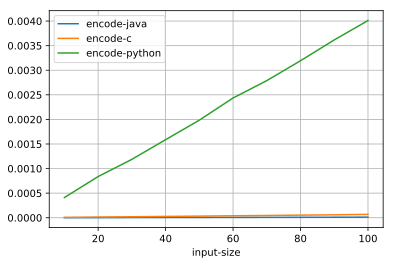

In [5]:
encoding[encoding['message'] == 'data-request'].sort_values(
    by='input-size'
).plot(
    x='input-size',
    y=['encode-java', 'encode-c', 'encode-python',
       #'decode-c-xml', 
    ],
    grid=True
)

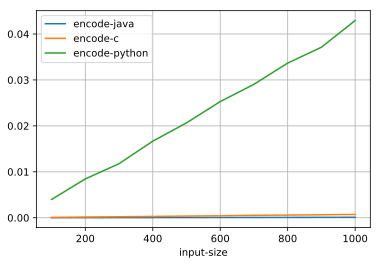

In [6]:
encoding[encoding['message'] == 'data-response'].sort_values(by='input-size').plot(
    x='input-size',
    y=['encode-java', 'encode-c', 'encode-python',
       #'decode-c-xml', 
      ],
    grid=True
)

# Decoding

In [7]:
decode_xml = data["decode-c"][data["decode-c"]["format"] == 'XER'].sort_values(
    by='input-size'
).drop(['bytes', 'format'], axis=1
      ).rename(columns={'decode-c': 'decode-c-xml'})

decoding = pd.merge(data["decode-python"], data["decode-c"], how='inner').drop(['bytes', 'format'], axis=1)
decoding = pd.merge(decoding, decode_xml, on=['message', 'input-size'], how='inner')
decoding = pd.merge(decoding, data["decode-java"], on=['message', 'input-size'], how='inner').drop(['format', 'bytes'], axis=1)

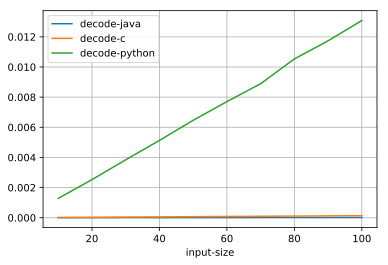

In [8]:
decoding[decoding['message'] == 'data-request'].sort_values(
    by='input-size'
).plot(
    x='input-size',
    y=['decode-java', 'decode-c', 'decode-python',
       #'decode-c-xml', 
      ],
    grid=True
)

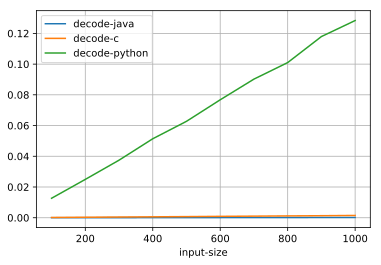

In [9]:
decoding[decoding['message'] == 'data-response'].sort_values(by='input-size').plot(
    x='input-size',
    y=['decode-java', 'decode-c', 'decode-python',
       #'decode-c-xml', 
      ],
    grid=True
)

## Message sizes

In [10]:
files = glob.iglob("../message-*")
sizes = []

for f in files:
    sizes.append({
        'size': int(os.stat(f).st_size),
        'format': f.split(".")[-1].upper(),
        'input-size': int(re.findall(r'\d+', f)[0]),
        'message': 'data-response' if 'data-response' in f else 'data-request'
    })

,BER,XER,PER,JER,UPER
10,1,6.41152,0.563786,4.31276,0.502058
20,1,6.50538,0.533333,4.3914,0.477419
30,1,6.39433,0.537589,4.3305,0.480851
40,1,6.45946,0.52973,4.37514,0.475676
50,1,6.40172,0.533906,4.34163,0.478112
60,1,6.44404,0.529242,4.36968,0.474368
70,1,6.40492,0.531692,4.34646,0.476308
80,1,6.43631,0.528455,4.36694,0.474255
90,1,6.40671,0.530935,4.34916,0.475779
100,1,6.43167,0.528416,4.36529,0.473753


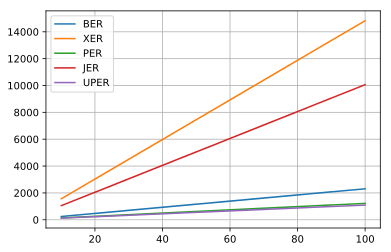

In [11]:
data_requests = pd.DataFrame(columns=[f.upper() for f in converter.OUTPUT_FORMATS])
for s in sizes:
    if s['message'] == 'data-request':
        index  =  s['input-size']
        format_ = s['format'] 
        value = s['size']
        data_requests.at[index, format_] = int(value)

data_requests.plot(grid=True)
data_requests.divide(data_requests["BER"], axis="index").sort_index() 

,BER,XER,PER,JER,UPER
100,1,3.52579,0.828175,2.27331,0.743388
200,1,3.51764,0.829273,2.26874,0.744427
300,1,3.51491,0.829578,2.26721,0.744712
400,1,3.51354,0.82973,2.26645,0.744854
500,1,3.51272,0.829822,2.26599,0.74494
600,1,3.51217,0.829883,2.26568,0.744997
700,1,3.51178,0.829926,2.26547,0.745038
800,1,3.51149,0.829959,2.2653,0.745068
900,1,3.51126,0.829985,2.26517,0.745092
1000,1,3.51108,0.830005,2.26507,0.745111


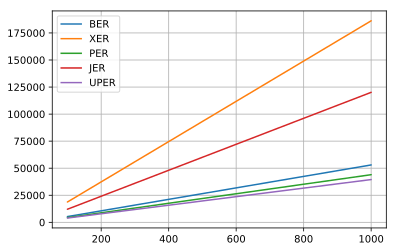

In [12]:
data_responses = pd.DataFrame(columns=[f.upper() for f in converter.OUTPUT_FORMATS])
for s in sizes:
    if s['message'] == 'data-response':
        index  =  s['input-size']
        format_ = s['format'] 
        value = s['size']
        data_responses.at[index, format_] = int(value)

data_responses.plot(grid=True)
data_responses.divide(data_responses["BER"], axis="index").sort_index() 